Power diagram
=============

Power diagram (or Laguerre diagram) can be considered as a generalization of Voronoi diagrams where each seeds has "weights", enabling moving/growing of the cells.

The convention is that $x$ is in cell $i$ if $\| x - \delta_i \|^2 - w_i < \| x - \delta_j \|^2 - w_j ,\ \forall j \neq i$.

In short, the `PowerDiagram` class
* handles virtual seeds, for periodicity handling,
* works with any number of dimension (>= 1),
* can work with large vectors (notably for out-of-core or MPI computations),
* is able to give siblings, parents or chilren for all the kinds of geometric entities.

It is optionaly equiped with an underlying measure (Lebesgue by default), for methods like `cell_integrals`, `cell.boundary_integrals`...

Internally, it is optimized for multicore and SIMD/SIMT instruction sets.

Construction and visualization
-----------------------------

### Basic example


In [ ]:
# pip install will install the source + some precompiled librairies for the most common hardwares and use cases.
# If the case is not pre-included, you will need to have a C++ compiler installed on your machine and sdot will
# automatically handle the build (it may take some time on the first use).
!pip install sdot


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.5/99.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 47.5 MB/s eta 0:00:00
  Created wheel for pysdot: filename=pysdot-0.2.24-cp310-cp310-linux_x86_64.whl size=16016449 sha256=b3fda21bf76db02cfcb52acde069459d42605209968699787cfb07977f6d6f32
  Stored in directory: /root/.cache/pip/wheels/a8/d2/9c/63b22bd73693bda2f87525f18efc6c5fd33b11ca74d9f2522a
Successfully built pysdot


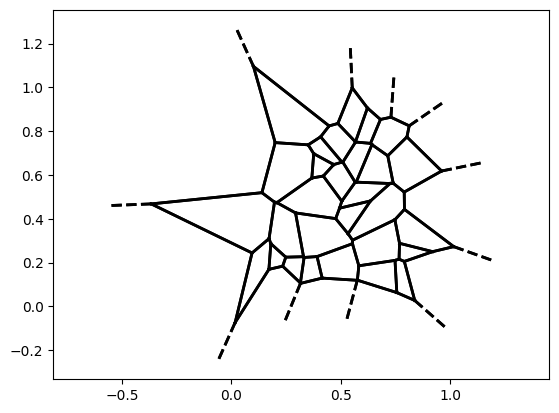

In [ ]:
from sdot import PowerDiagram
import numpy as np

# to get a nice picture
np.random.seed( 357 )

# we add some 2D seeds. By default, weights are equal to 1, leading to a voronoi diagram
pd = PowerDiagram( positions = np.random.random( [ 40, 2 ] ) )

# when display context is not specified, PowerDiagram.plot uses pyplot
pd.plot()

### Boundaries

Bounds are defined using affine functions:


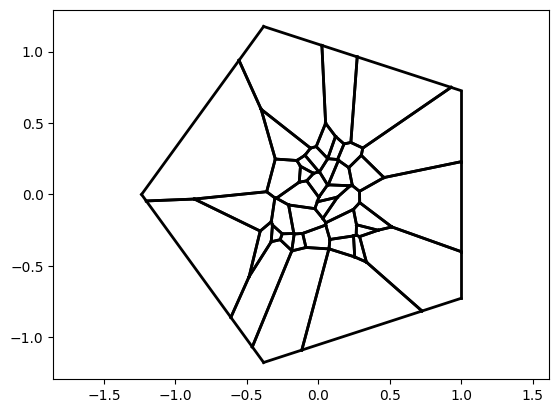

In [ ]:
# we center the points around 0 (we use a setter to change a value after call
# of the constructor)
pd.positions -= 0.5

# In this example we add 5 affine functions defined by the directions [ np.cos( a ), np.sin( a ) ] and offsets equal to 1
#   A point x is exterior when `dot( direction, x ) - offset > 0`
pd.boundaries = [ [ np.cos( a ), np.sin( a ), 1 ] for a in np.linspace( 0, 2 * np.pi, 5, endpoint = False ) ]

pd.plot()


### Periodicity

Periodicity is handled in sdot by virtual seed affine transformations. Everytime a user adds a transformation `T` (internally represented as a (nd+1)² matrix), sdot virtually adds a copy of the seed with `T` and `inverse( T )` transformations.

In this example, we add periodicity along the `y` axis:


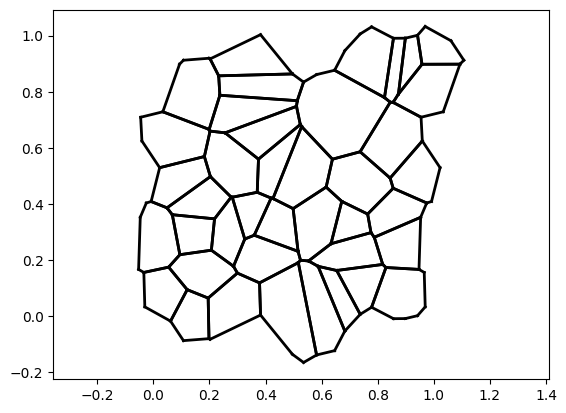

In [ ]:
pd = PowerDiagram( np.random.random( [ 40, 2 ] ) )

# We virtually repeat the seeds with `[ +/-1, +/-1 ]` translations.
#   Specifying `[ 0, 1 ]` and `[ 1, 0 ]`is enough because internally, inverse transformation and
#   transformations with previous transformations are automatically added
#   Rk: each new transformation T is added with its inv( T ), P @ T and P @ inv( T ) for each previous transformation P
# The transformations are internaly stored as transformation matrices (4x4 in 3D for instance)
#   it can be constructed using
#     * a (nd+1)² matrix
#     * or a tuple ( M, V ) to describe the transformation `M @ x + V` for a point `x`
#     * or by a single vector for a simple translation
pd.periodicity_transformations = [
    [ 1, 0 ],
    [ 0, 1 ]
]

pd.plot()


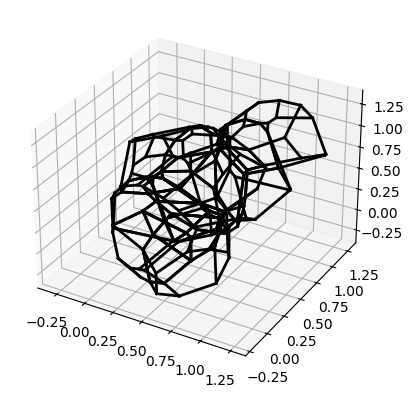

In [ ]:
# A simple 3D example
pd = PowerDiagram( positions = np.random.random( [ 10, 3 ] ) )
pd.periodicity_transformations = [
     [ 1, 0, 0 ],
     [ 0, 1, 0 ],
     [ 0, 0, 1 ]
]
pd.plot()

### VtkOutput

For large number of cells or complex 3D visualization, it is possible to generate files that can be read by softwares likes paraview...

Currently, only `.vtk` files are supported, but more are planed (notably via `PyVista`).


In [ ]:
pd = PowerDiagram( np.random.random( [ 500, 3 ] ) )
pd.periodicity_transformations = [
    [1,0,0],
    [0,1,0],
    [0,0,1],
]

# plot understands the string as a filename and checks the extension to call the right plot function
#  (which actually calls the pd.plot_vtk() function)
pd.plot( "out.vtk" )

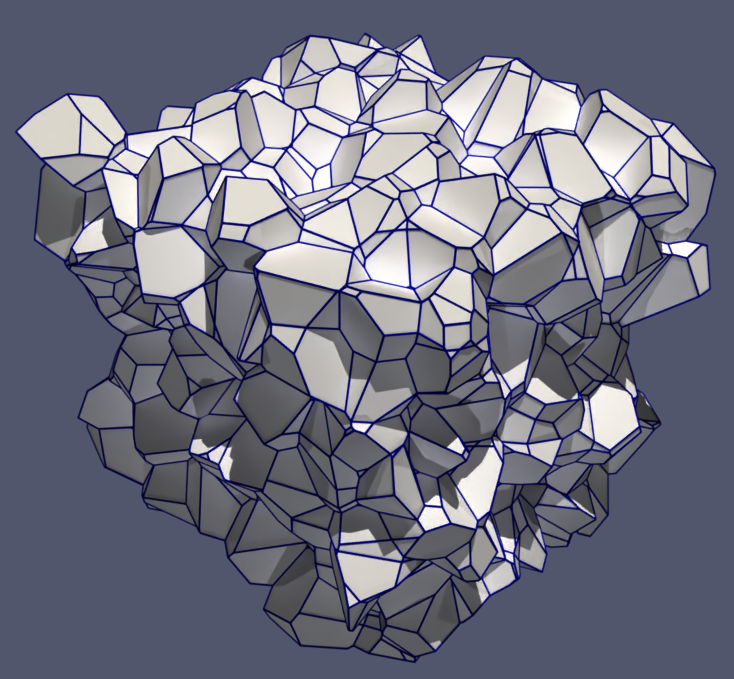

Cells
-----

### Sweeping

Cells can be scanned using the method `for_each_cell`. It calls the function given as argument with the cells (as instances of the class `Cell`).

`Cell` contains methods like `integral`, `boundaries`, ..., enabling individual computations for each, and for execution speed, most of theses methods have vectorized counterparts in the `PowerDiagram` class (prefixed with `cell_` and suffixed with a `s`). For instance for `cell.integral(...)` there is a method `power_diagram.cell_integrals(...)` that returns a list (with the computation actually done in the C++ code).

One comment: by default, to avoid unnecessary memory consumption, cells are computed on the fly. If the user plans to call methods that lead to the same cells being scanned several times (the diagram not being modified between the calls), and there's no particular memory pressure, it is possible to request caching with `power_diagram.use_cache = True` or set `use_cache = True` in argument of the methods that have this option. As we will see later, `PowerDiagram.summary()` is also a way to pool the computations.

### Lower dimensionality

Cells may be suported on spaces with lower dimensionnality. If it's the case, methods like `vertex_coords` or `vertex_refs` (i.e. the list of cuts indices for each vertex) will return arrays with `.shape[ 1 ] < ndim`.

It is illustrated in the following example


0
False
2
3
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


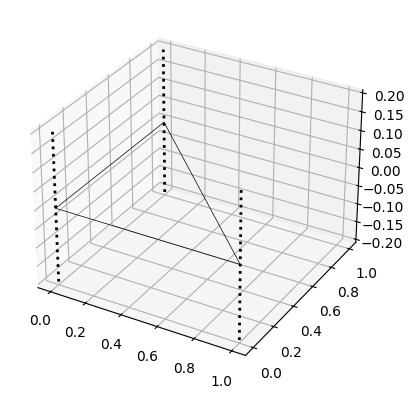

In [ ]:
from sdot import Cell

cell = Cell( ndim = 3 )

# we create a infinitely extruded triangle
cell.cut( [ -1,  0, 0 ], 0 )
cell.cut( [  0, -1, 0 ], 0 )
cell.cut( [ +1, +1, 0 ], 1 )

# of course, there's no 3D vertex...
print( cell.nb_vertices ) # => 0

# and this cell is sill unbounded (in the 3D space)
print( cell.bounded ) # => False

# ... it's because we're internally in 2D :)
print( cell.true_dimensionality ) # => 2

# "_td" is the shortcut suffix for "true dimensionality".
# Methods with prefix return the information for the subspace that is defined by `cell.base`
print( cell.nb_vertices_td ) # => 3 (the 3 vertices of the triangle)

# we can get sample coordinates to represent these points in ndim (3D in this case)
print( cell.vertex_coords_td @ cell.base ) # => [[0. 0. 0.] [1. 0. 0.] [0. 1. 0.]]

# visualization will show the "sub-dimensional" content with thiner lines
cell.plot()

Summary of coordinates, connectivity, parenting...
--------------------------------------------------

The method `PowerDiagram.summary` returns a `PowerDiagramSummary` object that contains arrays describing the fully computed power diagram. It contains the coordinates, the connectivity and parenting information.

For instance, for this simple power diagram

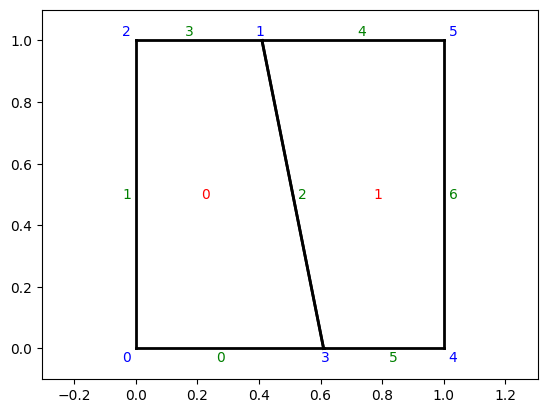

In [ ]:
from sdot import PowerDiagram
import pylab as plt
import numpy as np

def text( p, txt, color ):
    plt.text( p[ 0 ], p[ 1 ], txt, ha='center', va='center', color = color )

pd = PowerDiagram( [ [ 0.25, 0.5 ], [ 0.75, 0.6 ] ] )
pd.add_box_boundaries( 0, 1 )
ps = pd.summary()

# displau
b0 = ps.barycenters( dim = 0 )
b1 = ps.barycenters( dim = 1 )
b2 = ps.barycenters( dim = 2 )
bc = np.array([0.5,0.5])

pd.plot( plt )
for lb, color in zip( [ b0, b1, b2 ], [ 'blue', 'green', 'red' ]):
    for i, b in enumerate( lb ):
        dir = b - bc
        if np.linalg.norm( dir ):
            dir = dir / np.linalg.norm( dir )
        for e in range( 2 ):
            if abs( dir[ e ] ) >= 0.3:
                dir[ e ] = dir[ e ] / abs( dir[ e ] ) # * 0.5
        text( b + 0.03 * dir, f'{ i }', color )
plt.xlim( -0.1, 1.1 )
plt.ylim( -0.1, 1.1 )
plt.show()


In [ ]:
# ps.vertex_coords => coordinates for each vertex
# [[ 0.    0.  ]
#  [ 0.41  1.  ]
#  [ 0.    1.  ]
#  [ 0.61  0.  ]
#  [ 1.   -0.  ]
#  [ 1.    1.  ]]

# ps.ref_lists[ 0 ] => references for item of dimensionality 0, i.e. for vertices
#   if `reference <  ps.nb_seeds`, `reference` is a seed index (cell index if you wish)
#   if `reference >= ps.nb_seeds`, `reference` is a boundary index and equal to `ps.nb_seeds + boundary_index`
# In other words, ps.ref_lists[ 0 ] describes how the vertices have been constructed (by which cells and by which boundaries)
# [[0 2 4]
#  [0 1 5]
#  [0 2 5]
#  [0 1 4]
#  [1 3 4]
#  [1 3 5]]

# ps.ref_lists[ 1 ] => references for item of dimensionality 1 (i.e. for edges and rays)
# [[2 4]
#  [0 4]
#  [0 2]
#  [1 5]
#  [0 5]
#  [0 1]
#  [2 5]
#  [1 4]
#  [3 4]
#  [1 3]
#  [3 5]]

# ps.parenting => a ndim x ndim matrix for parent <-> children correspondance
# For instance
#   ps.parenting[ 2 ][ 0 ] => children of dim 0 (vertices) from items of dim 2 (faces)
# [0, 1, 2, 3]
# [1, 4, 3, 5]

#   ps.parenting[ 1 ][ 2 ] => parents of dim 2 (faces) from items of dim 1 (edges)
# [0]
# [0]
# [0, 1]
# [0]
# [1]
# [1]
# [1]

# ps.boundary_items => items indices of part that belong to each boundary item.
#   In this case, indices of edges included in each boudary item (by index of the boundary item)
# add_box_boundaries added the boundaries [ [-1,0,0], [1,0,1], [0,-1,0], [0,1,1] ]
# [[1], [6], [0, 5], [3, 4]]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-9-295378dbe475>, line 2)

Integrals
---------

The method `power_diagram.cell_integrals( f )` (or `cell.integral( f )` if you have a cell) takes as input a symbolic formula. By default, it uses the `power_diagram.underlying_measure` and the `power_diagram.underlying_radius_function` expressions so that the integral for each cell is equal to `integral( underlying_measure * underlying_radius_function * f, cell )`. If is possible to use another underlying measure of radius functions by using the `override_...` arguments.

`f` can be a scalar or a list, a list of list, etc... `power_diagram.cell_integrals` will accordingly return a scalar or a list, et...

Methods like `barycenters`, `mean`, ... work the same way


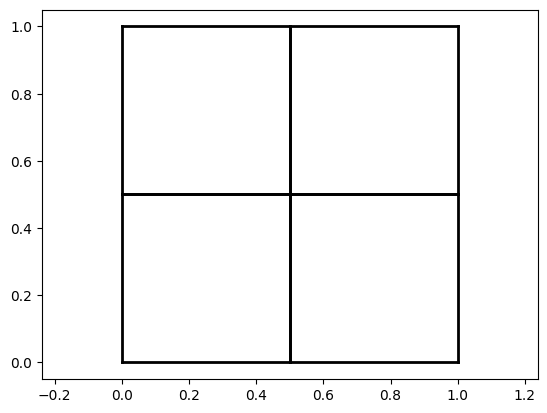

[0.25 0.25 0.25 0.25]
[0.   0.25 0.25 0.5 ]


In [ ]:
from sdot import ScaledImage

pd = PowerDiagram( [ [ 0.1, 0.1 ], [ 0.1, 0.9 ], [ 0.9, 0.1 ], [ 0.9, 0.9 ] ] )
pd.add_box_boundaries( 0, 1 )
pd.plot()

# c.integral() => integration of 1 on the cell
print( pd.cell_integrals() )

# by default piecewise constant, positionned in [0,1]^n
s = ScaledImage( [ [ 0, 1 ],[ 1, 2 ] ] )
print( pd.cell_integrals( s ) )
